In [1]:
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import cv2
import random
from PIL import Image

In [2]:
dataPath = Path("D:/lung_cancer/archive/ChestXray")
trainFolder = os.path.join(dataPath, "train")
valFolder = os.path.join(dataPath, "val")
testFolder = os.path.join(dataPath, "test")

In [3]:
train_image = os.path.join(trainFolder,"image")
train_mask = os.path.join(trainFolder, "mask")
val_image = os.path.join(valFolder,"image")
val_mask = os.path.join(valFolder, "mask")
test_image = os.path.join(testFolder,"image")
test_mask = os.path.join(testFolder, "mask")

In [4]:
train_image_list = glob.glob(train_image + "\\*.png")
train_mask_list = glob.glob(train_mask + "\\*.jpeg")
val_image_list = glob.glob(val_image + "\\*.png")
val_mask_list = glob.glob(val_mask + "\\*.jpeg")
test_image_list = glob.glob(test_image + "\\*.png")
test_mask_list = glob.glob(test_mask + "\\*.jpeg")

In [5]:
mask = cv2.imread(train_mask_list[9])

# Reshape the mask to treat each pixel's RGB values as a single entity
# This converts the mask from shape (512, 512, 3) to (262144, 3) for a 512x512 image
pixels = mask.reshape(-1,1)

# Find unique rows (unique RGB combinations) and their counts
unique_pixels, counts = np.unique(pixels, axis=0, return_counts=True)

# If needed, convert unique_pixels back to tuples to use them as dictionary keys
pixel_value_distribution = dict(zip(map(tuple, unique_pixels), counts))

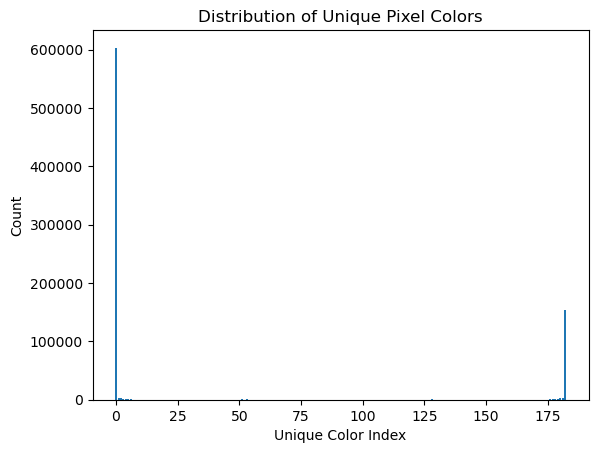

In [6]:
plt.bar(range(len(counts)), counts)
plt.title('Distribution of Unique Pixel Colors')
plt.xlabel('Unique Color Index')
plt.ylabel('Count')
plt.show()

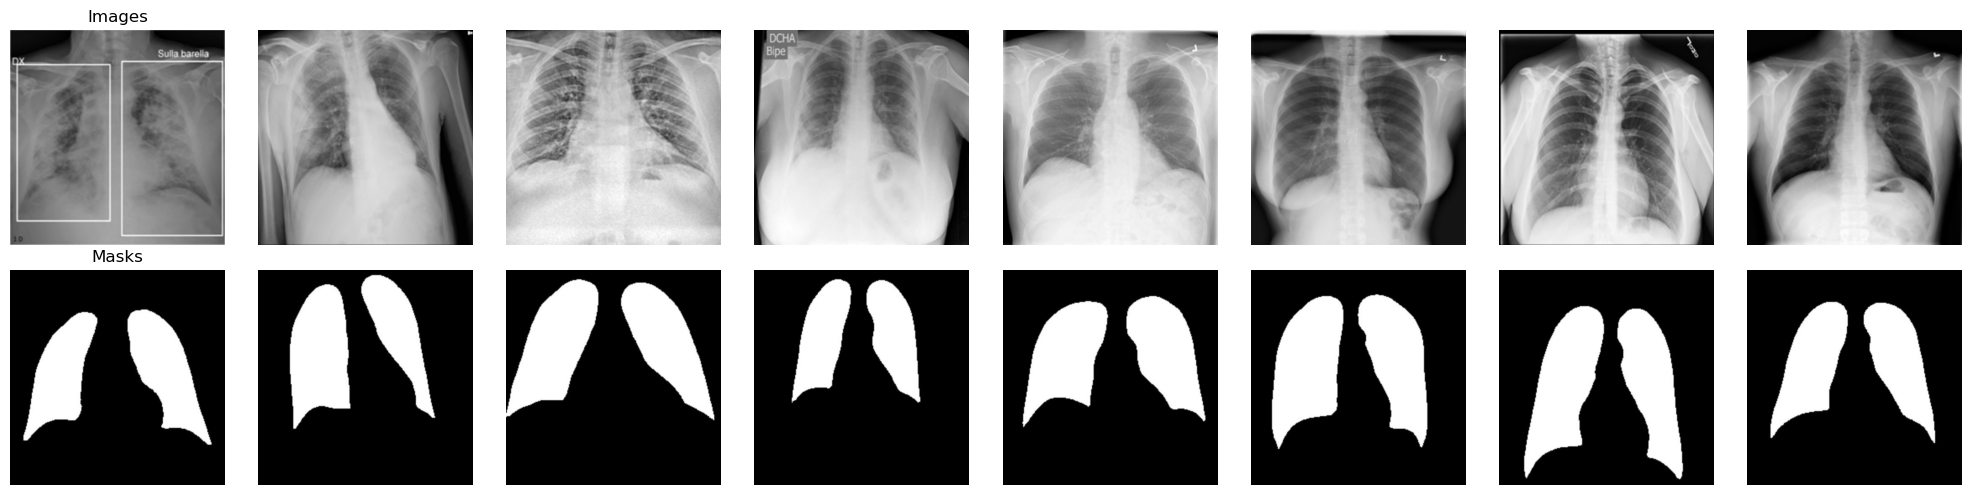

In [7]:
fig, axes = plt.subplots(2, 8, figsize=(20, 5)) # Adjust figsize to change the overall size of the grid

# Loop over the number of images
for i in range(8):
    # Read and convert the image from BGR to RGB
    img = cv2.cvtColor(cv2.imread(train_image_list[i+1]), cv2.COLOR_BGR2RGB) # Assuming the list starts from 1
    mask = cv2.cvtColor(cv2.imread(train_mask_list[i+1]), cv2.COLOR_BGR2RGB) # Adjust if your indexing is different

    # Plot the image
    axes[0, i].imshow(img)
    axes[0, i].axis('off')  # Remove axis ticks
    if i == 0:
        axes[0, i].set_title("Images") # Optional: Only adding title to the first of each row for clarity

    # Plot the mask
    axes[1, i].imshow(mask)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Masks")

plt.tight_layout()  # Adjust layout
plt.show()

In [8]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout, BatchNormalization, Activation, Reshape, ConvLSTM2D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

## define the model

In [9]:
def doubleconv2d(input_size, filter):
    temp = Conv2D(filter, 3, padding= "same", activation="relu", kernel_initializer= "he_normal")(input_size)
    output = Conv2D(filter, 3, padding= "same", activation="relu", kernel_initializer= "he_normal")(temp)
    return output

def down2d(input_size, filter):
    mapping = doubleconv2d(input_size, filter)
    temp2 = MaxPooling2D(2)(mapping)
    output = Dropout(0.1)(temp2)
    return mapping, output

def un2d(input_size, mapping, filter, shape):
    TransConv = Conv2DTranspose(filter, 3, 2, padding="same")(input_size)
    BN = BatchNormalization(axis=3)(TransConv)
    ACT = Activation('relu')(BN)
    MAP = Reshape(target_shape=(1, np.int32(shape), np.int32(shape), filter))(mapping)
    UP = Reshape(target_shape=(1, np.int32(shape), np.int32(shape), filter))(ACT)
    UP = Concatenate(axis = 1)([MAP,UP])
    UP = ConvLSTM2D(filters = filter, 
                            kernel_size=(3, 3), 
                            padding='same', 
                            return_sequences = False, 
                            go_backwards = True, 
                            kernel_initializer = 'he_normal')(UP)
    UP = Dropout(0.1)(UP)
    UP = doubleconv2d(UP, filter)
    return UP

def make_unet(input_size = (128, 128, 1)):
    inputs = Input(input_size)
    map1, down1 = down2d(inputs, 64)
    map2, down2 = down2d(down1, 128)
    map3, down3 = down2d(down2, 256)
    
    bottleneck1 = doubleconv2d(down3, 512)
    bottleneck2 = doubleconv2d(bottleneck1, 512)
    merge_dense = Concatenate(axis=3)([bottleneck1,bottleneck2])
    bottleneck3 = doubleconv2d(merge_dense, 512)

    up1 = un2d(bottleneck3, map3, 256, input_size[0]/4)
    up2 = un2d(up1, map2, 128, input_size[0]/2)
    up3 = un2d(up2, map1, 64, input_size[0])

    outputs = Conv2D(1, 1, padding="same", activation = "sigmoid")(up3)
    unet_model = Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [10]:
u_net = make_unet()

In [11]:
i = random.randint(0,len(train_image_list)-1)
img = np.asarray(Image.open(train_image_list[i]))
mask = np.asarray(Image.open(train_mask_list[i]))
print(img.shape,mask.shape)

(512, 512, 4) (512, 512, 3)


In [12]:
def make_dataset(validation=False):
    x = []
    y = []
    if(validation):
        for i,(image,mask) in enumerate(zip(val_image_list[:1500],val_mask_list[:1500])):
            print("\r"+str(i+1)+"/"+str(len(val_image_list)),end="")

        image = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/image",image)).convert('L') # Convert to grayscale
        mask = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/val/mask",mask)).convert('L')

        image = np.asarray(image.resize((128,128)))/255. # Normalization
        mask = np.asarray(mask.resize((128,128)))/255.

        x.append(image)
        y.append(mask)
    else:
        for i,(image,mask) in enumerate(zip(test_image_list[:3500],train_image_list[:3500])):
            print("\r"+str(i+1)+"/"+str(len(train_image_list)),end="")
    
        image = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/image",image)).convert('L')
        mask = Image.open(os.path.join("../input/lung-mask-image-dataset/ChestXray/train/mask",mask)).convert('L')

        image = np.asarray(image.resize((128,128)))/255.
        mask = np.asarray(mask.resize((128,128)))/255.

        x.append(image)
        y.append(mask)

    return np.array(x),np.array(y)

In [13]:
x,y = make_dataset()
v_x,v_y = make_dataset(True)

1500/21172

In [14]:
x,y = np.expand_dims(x,axis=-1),np.expand_dims(y,axis=-1)
v_x,v_y = np.expand_dims(v_x,axis=-1),np.expand_dims(v_y,axis=-1)

In [9]:
x,y = make_dataset()

3500/16932

In [10]:
v_x,v_y = make_dataset(True)

1500/2117

In [11]:
# Expand the shape of array to satisfy the input requirement of the model
x,y = np.expand_dims(x,axis=-1),np.expand_dims(y,axis=-1)
v_x,v_y = np.expand_dims(v_x,axis=-1),np.expand_dims(v_y,axis=-1)

In [16]:
data_gen_args = dict(
    rotation_range=20, # random angle
    width_shift_range=0.2, # horizontal rotation
    height_shift_range=0.2, # vertical rotation
    shear_range=0.2, # shear...
    zoom_range=0.2, # zoom ...
    fill_mode="nearest", #fill_mode：‘constant’，‘nearest’，‘reflect’或‘wrap’之一，当进行变换时超出边界的点将根据本参数给定的方法进行处理
    horizontal_flip=True, # random horizontally flip
    vertical_flip=True, # random vertically flip
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 42

image_generator = image_datagen.flow(
    x,
    batch_size=16,
    seed=seed)

mask_generator = mask_datagen.flow(
    y,
    batch_size=16,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

In [17]:
image_test_datagen = ImageDataGenerator()
mask_test_datagen = ImageDataGenerator()

seed = 42

image_test_generator = image_test_datagen.flow(
    v_x,
    batch_size=16,
    seed=seed)

mask_test_generator = mask_test_datagen.flow(
    v_y,
    batch_size=16,
    seed=seed)

valid_generator = zip(image_test_generator, mask_test_generator)

In [14]:
u_net.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

In [15]:
model_history = u_net.fit(train_generator, epochs=20, validation_data=valid_generator, steps_per_epoch = int(x.shape[0] / 8), validation_steps = int(v_x.shape[0] / 8))

Epoch 1/20
437/437 [==============================] - 231s 492ms/step - loss: 0.1512 - accuracy: 0.8811 - val_loss: 0.0949 - val_accuracy: 0.9308
Epoch 2/20
437/437 [==============================] - 213s 488ms/step - loss: 0.0645 - accuracy: 0.9081 - val_loss: 0.0878 - val_accuracy: 0.9325
Epoch 3/20
437/437 [==============================] - 213s 487ms/step - loss: 0.0539 - accuracy: 0.9103 - val_loss: 0.1113 - val_accuracy: 0.9242
Epoch 4/20
437/437 [==============================] - 213s 488ms/step - loss: 0.0477 - accuracy: 0.9115 - val_loss: 0.0624 - val_accuracy: 0.9392
Epoch 5/20
437/437 [==============================] - 213s 488ms/step - loss: 0.0456 - accuracy: 0.9120 - val_loss: 0.0796 - val_accuracy: 0.9339
Epoch 6/20
437/437 [==============================] - 213s 488ms/step - loss: 0.0467 - accuracy: 0.9115 - val_loss: 0.0768 - val_accuracy: 0.9363
Epoch 7/20
437/437 [==============================] - 213s 488ms/step - loss: 0.0397 - accuracy: 0.9132 - val_loss: 0.0644 -

In [16]:
u_net.save("mymodel.h5")

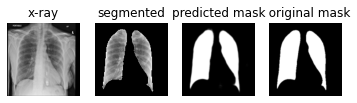

In [17]:
import matplotlib.pyplot as plt
i = random.randint(0,len(v_x)-1)

original = v_x[i].copy()
original_mask = v_y[i].copy()

mask = u_net.predict(np.expand_dims(original,axis=0))

segmented = np.squeeze(original).copy()
segmented[np.squeeze(mask)<0.2] = 0

plt.subplot(1,4,1)
plt.imshow(np.squeeze(original),cmap="gray")
plt.title("x-ray")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(segmented,cmap="gray")
plt.title("segmented")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(np.squeeze(mask[0]),cmap="gray")
plt.title("predicted mask")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(np.squeeze(original_mask),cmap="gray")
plt.title("  original mask")
plt.axis("off")

plt.show()